In [1]:
# Car Vehicle Detection

# Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled 
# training set of images and train a classifier Linear SVM classifier

# Optionally, you can also apply a color transform and append binned color features, 
# as well as histograms of color, to your HOG feature vector.

# Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

# Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and
# create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

# Estimate a bounding box for vehicles detected.


In [5]:
import numpy as np
import pickle
import cv2
import glob
import time
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from moviepy.editor import VideoFileClip

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label


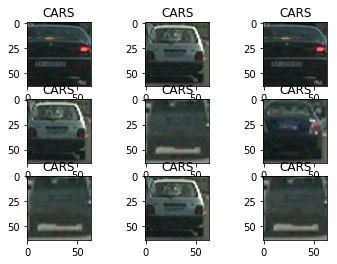

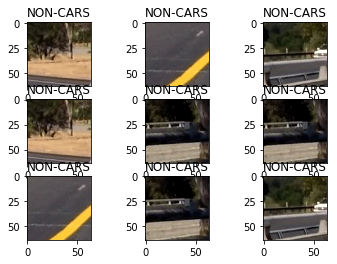

In [16]:
# Load car data and non-car data
cars = glob.glob("vehicles/**/*.png")
others = glob.glob("non-vehicles/**/*.png")

def show_samples(title, list):

    #let's now display a grid of images
    cell_w = 3
    cell_h = 3
    tmp_img, X_img_arr = plt.subplots(cell_w, cell_h)
    idx_row = 0
    for idx in range(0,9):
        col = idx % cell_w
        # plot on relevant subplot
        rand_idx = random.randint(0, len(X_img_arr)) #pick a random image in the dataset
        img = cv2.imread(list[rand_idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X_img_arr[col,idx_row].imshow(img)
        X_img_arr[col,idx_row].set_title(title)
        if col == (cell_w - 1):
             # we have finished the current row, so increment row counter
             idx_row += 1

show_samples("CARS", cars)
show_samples("NON-CARS", others)


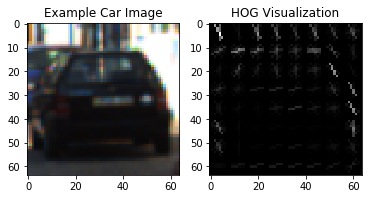

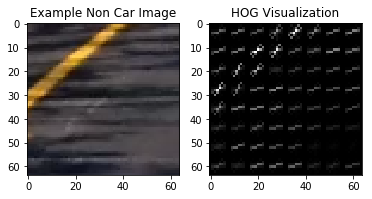

In [20]:
# Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled 
# training set of images

# Define a function to return HOG features and visualization
# Features will always be the first element of the return
# Image data will be returned as the second element if visualize= True
# Otherwise there is no second return element

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, 
                     feature_vec=True):
                         
    from skimage.feature import hog
    return hog(img, orientations=orient,
                              pixels_per_cell=(pix_per_cell, pix_per_cell), 
                              cells_per_block=(cell_per_block, cell_per_block), 
                              visualise=vis, feature_vector=feature_vec,
                              block_norm="L2-Hys")
                              

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


# Generate a random index to look at a NON car image
ind = np.random.randint(0, len(others))
# Read in the image
image = mpimg.imread(others[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)

fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Non Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [21]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features
